<a href="https://colab.research.google.com/github/Nedu21/Keras-deep-learning-projects/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an Autoencoder for Noise Removal
Learning objectives:
- Take noisy images and train an autoencoder to reconstruct clean images.
- Practice: encoder-decoder design, loss functions, transpose conv layers.

## Make necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.datasets import mnist

## Prepare your data

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

### Normalize & reshape data

In [4]:
# Split training data into training and validation sets
x_train, x_val, _, _ = train_test_split(x_train, x_train, test_size=10000, random_state=42)

# Normalize and reshape data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

train_clean = x_train.reshape(x_train.shape[0], 28, 28, 1)
val_clean = x_val.reshape(x_val.shape[0], 28, 28, 1)
test_clean = x_test.reshape(x_test.shape[0], 28, 28, 1)


print(train_clean.shape,'\n')
print(test_clean.shape, '\n')
print(val_clean.shape)

(50000, 28, 28, 1) 

(10000, 28, 28, 1) 

(10000, 28, 28, 1)


### Add Gaussian Noise



In [5]:
def add_gaussian_noise(image, noise_factor=0.6):
  noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
  # Clip values to ensure they remain within [0, 1]
  noisy_image = np.clip(noisy_image, 0., 1.)
  return noisy_image

In [6]:
train_noisy = add_gaussian_noise(train_clean)
val_noisy = add_gaussian_noise(val_clean)
test_noisy = add_gaussian_noise(test_clean)


print(train_noisy.shape, '\n')
print(test_noisy.shape, '\n')
print(val_noisy.shape)

(50000, 28, 28, 1) 

(10000, 28, 28, 1) 

(10000, 28, 28, 1)


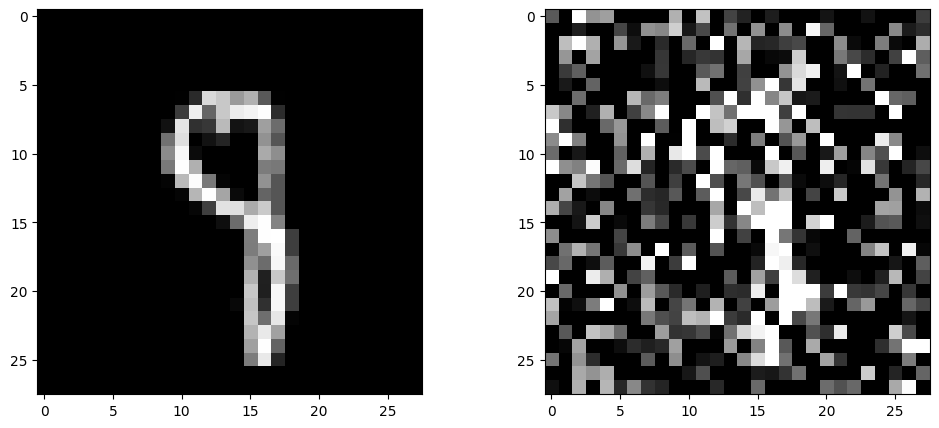

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(train_clean[0].reshape(28,28), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(train_noisy[0].reshape(28,28), cmap='gray')
plt.show()

## Build the Denoising Autoencoder Architecture

In [8]:
input_layer = Input(shape=(28, 28, 1))
# Encoder layer
x = Conv2D(16, (3,3), strides=(1,1), padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x) # Shape: (14, 14, 16)

x = Conv2D(32, (3,3), strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x) # Shape: (7, 7, 32)

# Decoder layer
x = Conv2D(32, (3,3), strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = UpSampling2D(size=(2,2))(x) # Shape: (14, 14, 32)

x = Conv2D(16, (3,3), strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = UpSampling2D(size=(2,2))(x) # Shape: (28, 28, 16)

output_layer = Conv2D(1, (3,3), strides=(1,1), padding='same', activation='sigmoid')(x)


autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,201 (75.00 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 192 (768.00 B)

### Train the model

In [9]:
history = autoencoder.fit(train_noisy, train_clean,
                          epochs=25,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(val_noisy, val_clean))

Epoch 1/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0731 - val_loss: 0.0219
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0188 - val_loss: 0.0176
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0164 - val_loss: 0.0162
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0156 - val_loss: 0.0157
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0153 - val_loss: 0.0157
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0152 - val_loss: 0.0155
Epoch 9/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0150 - val_loss: 0.0152
Epoch 10/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0149 - val_loss: 0.0153
Epoch 11/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0148 - val_loss: 0.0150
Epoch 12/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/st

In [10]:
# Predict denoised images
denoised = autoencoder.predict(test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


### Plot and visualize the predictions

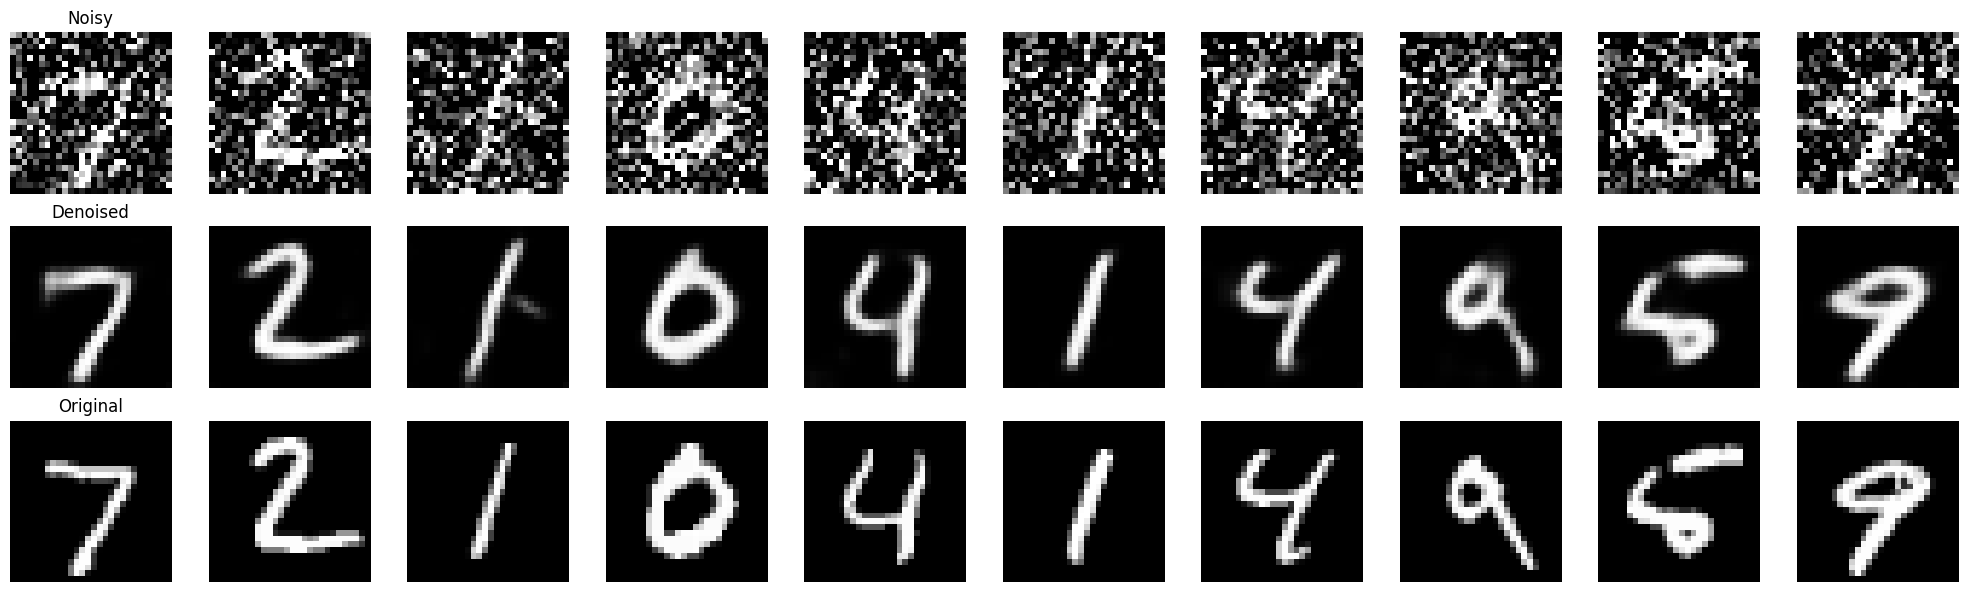

In [11]:
# Plot results
fig, axes = plt.subplots(3, 10, figsize=(20, 6))
for i in range(10):
    axes[0, i].imshow(test_noisy[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Noisy', fontsize=12)

    axes[1, i].imshow(denoised[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Denoised', fontsize=12)

    axes[2, i].imshow(test_clean[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_title('Original', fontsize=12)

plt.tight_layout()
plt.show()

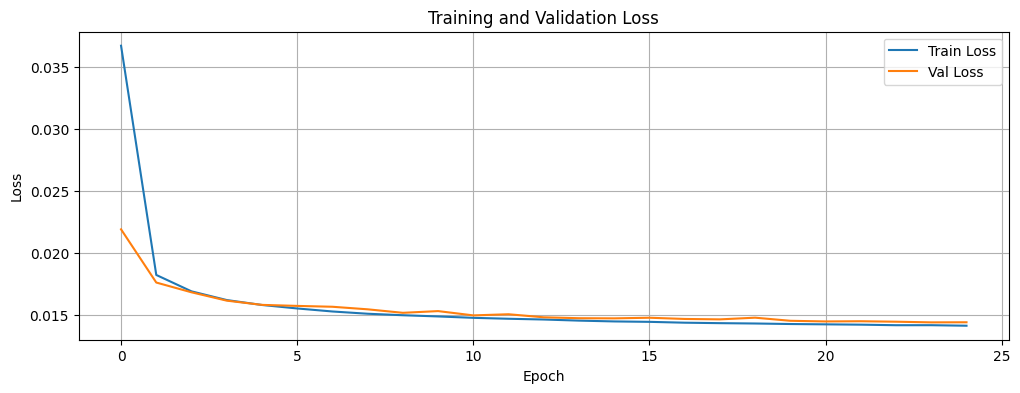

In [12]:
# Plot training loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()